## Install Dependencies

In [2]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Union
import os
import warnings
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from datasets.utils.logging import disable_progress_bar, set_verbosity_error
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import (
    Metrics, Context, ndarrays_to_parameters, NDArrays, Scalar,
    EvaluateIns, EvaluateRes, FitIns, FitRes, Parameters,
    parameters_to_ndarrays
)
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, Strategy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["DATASETS_VERBOSITY"] = "error"
warnings.filterwarnings("ignore", category=UserWarning, module="datasets")
logging.getLogger("datasets").setLevel(logging.ERROR)

warnings.filterwarnings("ignore", message=".*No fit_metrics_aggregation_fn provided.*")
warnings.filterwarnings("ignore", message=".*No evaluate_metrics_aggregation_fn provided.*")

logging.getLogger("flwr").setLevel(logging.INFO)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()
set_verbosity_error()

Training on cpu
Flower 1.19.0 / PyTorch 2.7.1+cpu


## Load the data

In [3]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

def load_datasets(partition_id: int, num_partitions: int):
    import os
    import warnings
    import logging
    os.environ["HF_DATASETS_OFFLINE"] = "1"
    os.environ["DATASETS_VERBOSITY"] = "error"
    warnings.filterwarnings("ignore", category=UserWarning, module="datasets")
    logging.getLogger("datasets").setLevel(logging.ERROR)
    
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

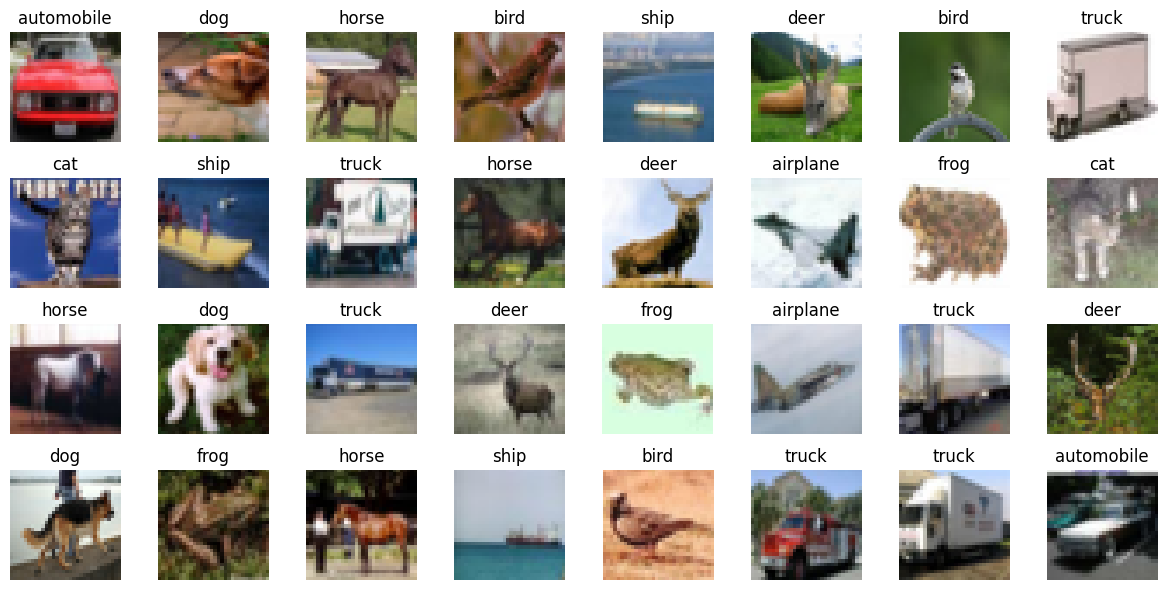

In [4]:
trainloader, _, _ = load_datasets(partition_id=0, num_partitions=NUM_CLIENTS)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]

images = images.permute(0, 2, 3, 1).numpy()
images = images / 2 + 0.5

fig, axs = plt.subplots(4, 8, figsize=(12, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    classes = [
        "airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck"
    ]
    ax.set_title(classes[labels[i]])
    ax.axis("off")
fig.tight_layout()
plt.show()

# Step 1: Centralized Learning with PyTorch

## Define the model

In [5]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train the model

In [6]:
def train(net, trainloader, epochs: int):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [7]:
trainloader, valloader, testloader = load_datasets(partition_id=0, num_partitions=NUM_CLIENTS)
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: train loss 0.066434845328331, accuracy 0.20825
Epoch 1: validation loss 0.06159801614284515, accuracy 0.303
Epoch 1: train loss 0.058179114013910294, accuracy 0.32425
Epoch 2: validation loss 0.05547057008743286, accuracy 0.38
Epoch 1: train loss 0.0535370297729969, accuracy 0.3715
Epoch 3: validation loss 0.05098864817619324, accuracy 0.424
Epoch 1: train loss 0.05028659850358963, accuracy 0.41825
Epoch 4: validation loss 0.049485122203826906, accuracy 0.442
Epoch 1: train loss 0.04803788661956787, accuracy 0.4495
Epoch 5: validation loss 0.048654653072357175, accuracy 0.454
Final test set performance:
	loss 0.04949730939865112
	accuracy 0.4277


# Step 2: Federated Learning with Flower

## Update model parameters

In [8]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## Define Flower ClientApp

In [9]:
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        
        lr = config.get("lr", 0.001)
        if isinstance(lr, (int, float)):
            lr = float(lr)
        else:
            lr = 0.001
            
        self._train_with_lr(self.net, self.trainloader, epochs=1, lr=lr)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}
    
    def _train_with_lr(self, net, trainloader, epochs: int, lr: float):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
        net.train()
        for epoch in range(epochs):
            for batch in trainloader:
                images, labels = batch["img"], batch["label"]
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()
                outputs = net(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

In [10]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    partition_id = int(context.node_config["partition-id"])
    num_partitions = int(context.node_config["num-partitions"])
    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [11]:
params = get_parameters(Net())

def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=0.3,
        fraction_evaluate=0.3,
        min_fit_clients=3,
        min_evaluate_clients=3,
        min_available_clients=NUM_CLIENTS,
        initial_parameters=ndarrays_to_parameters(params),
    )

    config = ServerConfig(num_rounds=3)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

In [12]:
backend_config = {"client_resources": None}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_gpus": 1.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      a

## Define the Flower ServerApp

In [13]:
strategy = FedAvg(
    fraction_fit=1.0, 
    fraction_evaluate=0.5,  
    min_fit_clients=10,  
    min_evaluate_clients=5,  
    min_available_clients=10,
)

In [14]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

## Run training

In [15]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [16]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,  # type: ignore
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      

In [17]:
from flwr.common.typing import Scalar
from typing import Dict, List, Tuple

def weighted_average(metrics: List[Tuple[int, Dict[str, Scalar]]]) -> Dict[str, Scalar]:
    accuracies: List[float] = []
    examples: List[int] = []

    for num_examples, m in metrics:
        acc = m.get("accuracy", 0.0)
        if isinstance(acc, (int, float)):
            accuracies.append(num_examples * float(acc))
            examples.append(num_examples)

    total_accuracy = sum(accuracies)
    total_examples = sum(examples)

    return {"accuracy": total_accuracy / total_examples if total_examples > 0 else 0.0}

In [18]:
def server_fn(context: Context) -> ServerAppComponents:
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=10,
        min_evaluate_clients=5,
        min_available_clients=10,
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

server = ServerApp(server_fn=server_fn)

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,  # type: ignore
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      

# Step 3: Custom Strategy and Large Scale Simulation

## Build a Custom Strategy from Scratch

In [ ]:
class FedCustom(Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients

    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        net = Net()
        ndarrays = get_parameters(net)
        return ndarrays_to_parameters(ndarrays)

    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size, min_num_clients = self.num_fit_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        n_clients = len(clients)
        half_clients = n_clients // 2
        standard_config: Dict[str, Scalar] = {"lr": 0.001}
        higher_lr_config: Dict[str, Scalar] = {"lr": 0.003}
        fit_configurations = []
        for idx, client in enumerate(clients):
            if idx < half_clients:
                fit_configurations.append((client, FitIns(parameters, standard_config)))
            else:
                fit_configurations.append(
                    (client, FitIns(parameters, higher_lr_config))
                )
        return fit_configurations

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:

        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        if self.fraction_evaluate == 0.0:
            return []
        config: Dict[str, Scalar] = {}
        evaluate_ins = EvaluateIns(parameters, config)

        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        # No server-side evaluation for this custom strategy    
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [20]:
def server_fn_custom_small(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=2)
    return ServerAppComponents(
        config=config,
        strategy=FedCustom(
            fraction_fit=0.3,
            fraction_evaluate=0.3,
            min_fit_clients=3,
            min_evaluate_clients=3,
            min_available_clients=NUM_CLIENTS,
        ),
    )

server_custom_small = ServerApp(server_fn=server_fn_custom_small)

backend_config_custom = {"client_resources": None}
if DEVICE == "cuda":
    backend_config_custom = {"client_resources": {"num_gpus": 1.0}}

run_simulation(
    server_app=server_custom_small,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config_custom,
)

INFO :      Starting Flower ServerApp, config: num_rounds=2, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 10)
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      configure_evaluate: strategy sampled 3 clients (out of 10)
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 2 round(s) in 24.56s
INFO :      	History (loss, distr

### Large Scale Simulation (1000 clients)

In [21]:
def server_fn_custom_large(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=3)
    return ServerAppComponents(
        config=config,
        strategy=FedCustom(
            fraction_fit=0.01,
            fraction_evaluate=0.01,
            min_fit_clients=10,
            min_evaluate_clients=10,
            min_available_clients=1000,
        ),
    )

server_custom_large = ServerApp(server_fn=server_fn_custom_large)

backend_config_large: Dict[str, Scalar] = {"client_resources": None}
if DEVICE == "cuda":
    backend_config_large = {"client_resources": {"num_gpus": 0.1}}

run_simulation(
    server_app=server_custom_large,
    client_app=client,
    num_supernodes=1000,
    backend_config=backend_config_large,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 1000)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 1000)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 1000)
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 1000)
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 

## Summary and Comparison

This notebook demonstrates three different approaches to training a neural network on CIFAR-10:

1. **Step 1: Centralized Training** - Traditional single-machine training with all data
2. **Step 2: Standard Federated Learning** - Basic FL with FedAvg strategy (10 clients)
3. **Step 3: Custom Strategy + Large Scale** - Custom heterogeneous learning rates (1000 clients)

### Key Observations:
- **Centralized**: Fastest convergence, access to all data
- **Standard FL**: Distributed training, uniform learning rates
- **Custom Strategy**: Heterogeneous learning rates, massive scale (1000 clients)

The custom strategy allows testing different learning rate distributions across clients, which can be useful for:
- Simulating heterogeneous client capabilities
- Testing adaptive learning rate strategies
- Large-scale federated learning scenarios

### Next Steps:
- Experiment with different learning rate distributions
- Add client dropout simulation
- Test with different data partitioning strategies